# Assignment 9

Neural need huge amount of data to be able to perform well. Huge amount of data means huge computation power... To bypass the fact that we don't own this kind of machine, we will us the transfer leaning. By using a pretrained network (usually on ImageNet) and train it a little bit, we can avoid most of the computationnal power needed to perform our task. We will work on the ResNet network (https://arxiv.org/pdf/1512.03385.pdf) designed in 2014. 
Then, because we know you all have a degree in medicine, we will try our luck bu doing some! We will then retrain the last layer of the network to be able to recognize leopard and cheetah. The cheetah mini database is in the image folder.

In [4]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

print(torch)

plt.ion()   # interactive mode

<module 'torch' from '/usr/local/lib/python3.6/dist-packages/torch/__init__.py'>


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
data_dir = '/content/drive/My Drive/Colab Notebooks/images/cheetah_data_mini'
TRAIN = 'train'
TEST = 'val'

# ResNet Takes 224x224 images as input, so we resize all of them
data_transforms = {
    TRAIN: transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    TEST: transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {
    x: datasets.ImageFolder(
        os.path.join(data_dir, x), 
        transform=data_transforms[x]
    )
    for x in [TRAIN, TEST]
}

dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=4,
        shuffle=True, num_workers=4
    )
    for x in [TRAIN, TEST]
}

dataset_sizes = {x: len(image_datasets[x]) for x in [TRAIN, TEST]}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

for x in [TRAIN, TEST]:
    print("Loaded {} images under {}".format(dataset_sizes[x], x))
    
print("Classes: ")
class_names = image_datasets[TRAIN].classes
print(image_datasets[TRAIN].classes)

cuda:0
Loaded 450 images under train
Loaded 162 images under val
Classes: 
['cheetah', 'leopard', 'unknown']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 228, 906])
torch.Size([3, 228])


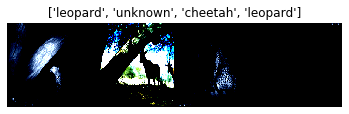

In [7]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    # plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    print(out.shape)
    print(out[:,:,15].shape)
    imshow(out, title=[class_names[x] for x in classes])


# Get a batch of training data
inputs, classes = next(iter(dataloaders[TRAIN]))
show_databatch(inputs, classes)

## Pretrained network

Now load a network pre-trained on Imagenet and classify the validation data. You can import a pretrained model directly from pytorch with models.resnet18(pretrained=True). The labels are already used in ImageNet so try to recognize the database directly using the output of the pretrained network on the validation database.

In [8]:
# NET
model_vanilla = torchvision.models.resnet18(pretrained=True)
# model_vanilla = model_vanilla.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 25.8MB/s]


In [0]:
for param in model_vanilla.parameters():
    param.requires_grad = False

In [0]:
# cheetah = 293; leopard = 288;

In [11]:
# TEST THE NET ON OUR DATASET
def switch_class_idx(predicted):
    for x in range(predicted.shape[0]):
        if predicted[x] == 293:
            predicted[x] = 0
        elif predicted[x] == 288:
            predicted[x] = 1
        else:
            predicted[x] = 2
    return predicted

def val_pretrained(model):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloaders[TEST]:
            inputs, labels = data
            # inputs = inputs.to(device)
            # labels = labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            # print(predicted)
            predicted = switch_class_idx(predicted)
            #print(labels, predicted)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy: %d %%' % (
        100 * correct / total))

val_pretrained(model_vanilla)

Accuracy: 33 %


## Transfer learning

The pre-trained network can now be further trained with our data. Replace the last layer in the network with a fully connected Layer with 3 outputs for our classes cheetah, leopard and unknown. Then train the last layer of the network.

In [0]:
import copy


def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in [TRAIN, TEST]:
            if phase == TRAIN:
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                # inputs = inputs.to(device)
                # labels = labels.to(device)
                
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == TRAIN):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    # backward + optimize only if in training phase
                    if phase == TRAIN:
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                    
            if phase == TRAIN:
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [0]:
# FEATURE EXTRACTING
model_extract = torchvision.models.resnet18(pretrained=True)
for param in model_extract.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_extract.fc.in_features
model_extract.fc = nn.Linear(num_ftrs, 3)
# model_extract = model_extract.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_ext = optim.SGD(model_extract.fc.parameters(), lr=.0001, momentum=0.9)

# Decay LR by a factor
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ext, step_size=5, gamma=0.1)

In [17]:
model_extract = train_model(model_extract, criterion, optimizer_ext,
                         exp_lr_scheduler, num_epochs=50)

Epoch 1/50
----------
train Loss: 0.6311 Acc: 0.8111
val Loss: 0.8420 Acc: 0.5679

Epoch 2/50
----------
train Loss: 0.6781 Acc: 0.7467
val Loss: 0.8289 Acc: 0.6420

Epoch 3/50
----------
train Loss: 0.6274 Acc: 0.7756
val Loss: 0.8256 Acc: 0.6111

Epoch 4/50
----------
train Loss: 0.6341 Acc: 0.7778
val Loss: 0.7828 Acc: 0.7160

Epoch 5/50
----------
train Loss: 0.6181 Acc: 0.7978
val Loss: 0.8357 Acc: 0.6049

Epoch 6/50
----------
train Loss: 0.6768 Acc: 0.7400
val Loss: 0.8089 Acc: 0.6111

Epoch 7/50
----------
train Loss: 0.6442 Acc: 0.7822
val Loss: 0.8537 Acc: 0.6235

Epoch 8/50
----------
train Loss: 0.6708 Acc: 0.7489
val Loss: 0.8059 Acc: 0.6235

Epoch 9/50
----------
train Loss: 0.6500 Acc: 0.7556
val Loss: 0.8358 Acc: 0.5926

Epoch 10/50
----------
train Loss: 0.6116 Acc: 0.7889
val Loss: 0.8594 Acc: 0.5617

Epoch 11/50
----------
train Loss: 0.6794 Acc: 0.7622
val Loss: 0.8166 Acc: 0.6049

Epoch 12/50
----------
train Loss: 0.6256 Acc: 0.8044
val Loss: 0.8217 Acc: 0.6358

E

In [18]:
def val_extract(model):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloaders[TEST]:
            inputs, labels = data
            # inputs = inputs.to(device)
            # labels = labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            #print(labels, predicted)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy: %d %%' % (
        100 * correct / total))
    
val_extract(model_extract)

Accuracy: 71 %
